In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pathlib 

data_dir = pathlib.Path("/kaggle/input/100-bird-species/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # creating the list of birds(class) names 
print(class_names)
# these are all the birds present in the dataset

['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'AFRICAN PIED HORNBILL' 'AFRICAN PYGMY GOOSE'
 'ALBATROSS' 'ALBERTS TOWHEE' 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH'
 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET' 'AMERICAN BITTERN'
 'AMERICAN COOT' 'AMERICAN DIPPER' 'AMERICAN FLAMINGO'
 'AMERICAN GOLDFINCH' 'AMERICAN KESTREL' 'AMERICAN PIPIT'
 'AMERICAN REDSTART' 'AMERICAN ROBIN' 'AMERICAN WIGEON'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY STORM PETREL'
 'ASHY THRUSHBIRD' 'ASIAN CRESTED IBIS' 'ASIAN DOLLARD BIRD'
 'ASIAN GREEN BEE EATER' 'ASIAN OPENBILL STORK' 'AUCKLAND SHAQ'
 'AUSTRAL CANASTERO' 'AUSTRALASIAN FIGBIRD' 'AVADAVAT' 'AZARAS SPINETAIL'
 'AZURE BREASTED PITTA' 'AZURE JAY' 'AZURE TANAGER' 'AZURE TIT'
 'BAIKAL TEAL' 'BALD EAGLE

In [3]:
import os
import matplotlib.image as mpimg

def view_bird_image(target_dir, target_class,ind):
    # ind is the index of the image in the class
  target_folder = target_dir + target_class
  img_b = os.listdir(target_folder)  

  img = mpimg.imread(target_folder +'/' + img_b[ind])  # this will always show the first image of the class
  plt.imshow(img)
  plt.title(target_class)
  return img

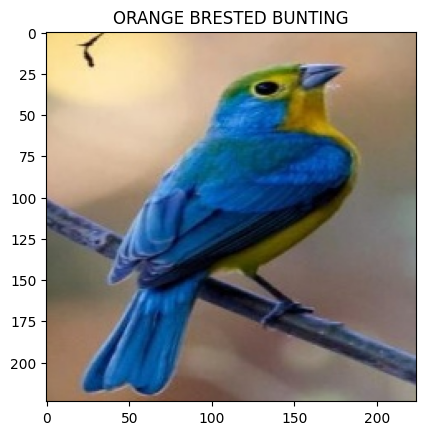

In [4]:
img = view_bird_image(target_dir = "/kaggle/input/100-bird-species/train/",target_class = "ORANGE BRESTED BUNTING",ind = 0) 

In [5]:
img.shape

(224, 224, 3)

**Preprocessing**

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

2024-07-24 13:48:35.207210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 13:48:35.207315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 13:48:35.361047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
train_dir = "/kaggle/input/100-bird-species/train"
test_dir = "/kaggle/input/100-bird-species/test/"
val_dir = "/kaggle/input/100-bird-species/valid/"

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Data transfer from directories to batches
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = valid_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


**Model**

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [10]:
#InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Adding a custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=5
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/2644 ━━━━━━━━━━━━━━━━━━━━ 19:48:27 27s/step - accuracy: 0.0000e+00 - loss: 6.2746

I0000 00:00:1721828966.589420      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721828966.645565      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 192/2644 ━━━━━━━━━━━━━━━━━━━━ 21:41 531ms/step - accuracy: 0.0383 - loss: 6.0589

W0000 00:00:1721829067.942612      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.3258 - loss: 3.4710

W0000 00:00:1721830259.902708      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2644/2644 ━━━━━━━━━━━━━━━━━━━━ 1336s 495ms/step - accuracy: 0.3259 - loss: 3.4706 - val_accuracy: 0.7031 - val_loss: 1.1840
Epoch 2/5
   1/2644 ━━━━━━━━━━━━━━━━━━━━ 3:11 73ms/step - accuracy: 0.5625 - loss: 1.3533

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2644/2644 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5625 - loss: 1.3533 - val_accuracy: 0.0000e+00 - val_loss: 2.1248
Epoch 3/5
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 949s 358ms/step - accuracy: 0.6779 - loss: 1.2922 - val_accuracy: 0.7706 - val_loss: 0.8651
Epoch 4/5
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.6562 - loss: 1.3048 - val_accuracy: 0.0000e+00 - val_loss: 2.7227
Epoch 5/5
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 950s 358ms/step - accuracy: 0.7496 - loss: 0.9819 - val_accuracy: 0.8037 - val_loss: 0.7235


In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data, steps=test_data.samples // test_data.batch_size)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.8294 - loss: 0.6475
Test accuracy: 83.61%


In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [14]:
# prediction
def predict_bird_species(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    
    # Get the class label
    predicted_label = class_names[predicted_class[0]]
    
    return predicted_label

In [15]:
#     MAKING PREDICTION

In [16]:
image_path = "/kaggle/input/100-bird-species/test/ABYSSINIAN GROUND HORNBILL/1.jpg"
pred = predict_bird_species(image_path)
print("the bird name is >>> ", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
the bird name is >>>  ABYSSINIAN GROUND HORNBILL


In [17]:
image_path = "/kaggle/input/100-bird-species/test/AMERICAN PIPIT/1.jpg"
pred = predict_bird_species(image_path)
print("the bird name is >>> ", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
the bird name is >>>  AMERICAN PIPIT


In [18]:
#model.save('bird_species_pred_nodel.h5')

In [19]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

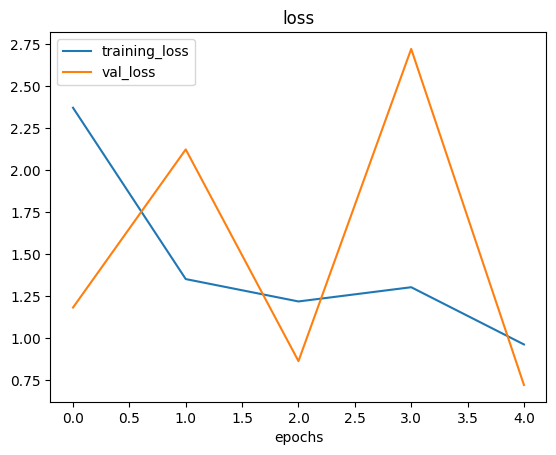

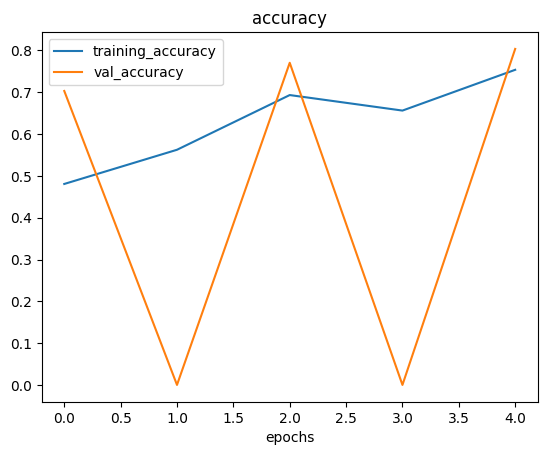

In [20]:
plot_loss_curves(history)

In [21]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [22]:
# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
fine_tune_history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=5
)

Epoch 1/5
   2/2644 ━━━━━━━━━━━━━━━━━━━━ 5:07 116ms/step - accuracy: 0.6250 - loss: 1.7368  

W0000 00:00:1721832245.090391      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1352/2644 ━━━━━━━━━━━━━━━━━━━━ 7:59 371ms/step - accuracy: 0.7821 - loss: 1.1010

W0000 00:00:1721832746.099768      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7943 - loss: 1.0152

W0000 00:00:1721833228.304273      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2644/2644 ━━━━━━━━━━━━━━━━━━━━ 1012s 375ms/step - accuracy: 0.7944 - loss: 1.0152 - val_accuracy: 0.8651 - val_loss: 0.5676
Epoch 2/5
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9062 - loss: 0.5642 - val_accuracy: 0.0000e+00 - val_loss: 2.8268
Epoch 3/5
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 975s 368ms/step - accuracy: 0.8382 - loss: 0.7065 - val_accuracy: 0.8796 - val_loss: 0.4860
Epoch 4/5
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.8750 - loss: 0.6395 - val_accuracy: 1.0000 - val_loss: 0.0962
Epoch 5/5
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 981s 370ms/step - accuracy: 0.8610 - loss: 0.5994 - val_accuracy: 0.8876 - val_loss: 0.4423


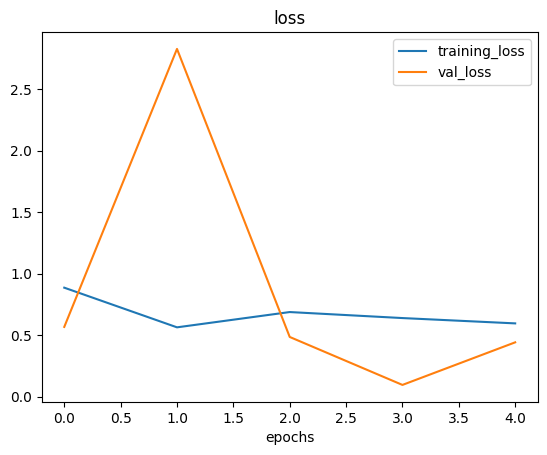

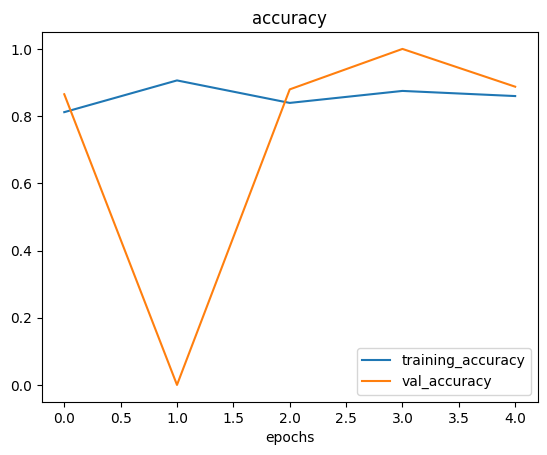

In [23]:
plot_loss_curves(fine_tune_history)

In [24]:
# evaluate the model
model.evaluate(test_data)

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9039 - loss: 0.3684


[0.36329150199890137, 0.9081904888153076]

In [25]:
test_loss, test_accuracy = model.evaluate(test_data, steps=test_data.samples // test_data.batch_size)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8983 - loss: 0.3882
Test accuracy: 90.82%


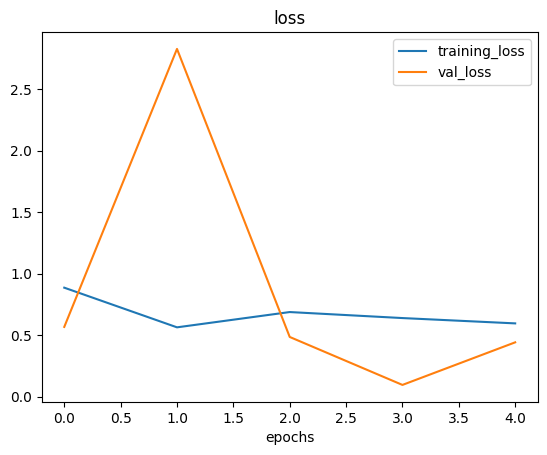

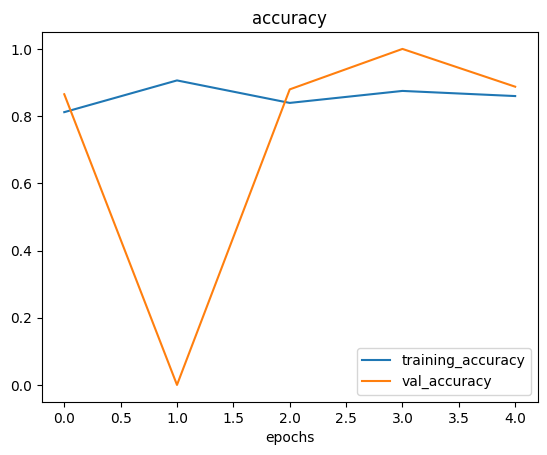

In [26]:
plot_loss_curves(fine_tune_history)